# **Приложение**
## **Отображение и анализ результатов обработки данных**

## Загрузка данных

In [494]:
from IPython.display import display,HTML
display(HTML('<style>.container {width: 80% !important}</style>'))

In [264]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import xarray as xr

import os
import math as m

In [788]:
directory = "E:/Climate/t7/"

file_list = np.array ([file for file in os.listdir(directory) if file.endswith('.nc')])

In [787]:
# Aggregating files by dictionaries: 
# timcor (2d spatial data), fldcor (array of values by timesteps), timmean (single value)
# tr_A and tr_B contain parameters of linear trends of anomalies time series (average values in my region)
file_dict = {}
timcor = {}
fldcor = {}
timmean = {}
tr_A = {}
tr_B = {}
for file in file_list:
    dataset = xr.open_dataset(os.path.join(directory, file), decode_times=False)
    file_dict[file] = dataset
    if 'timcor' in file:
        timcor[file] = dataset
    if 'fldcor' in file and not 'timmean' in file:
        fldcor[file] = dataset
    if 'timmean' in file:
        timmean[file] = dataset
    if 'fldmean_trend1' in file:
        tr_A[file.split('trend1_')[1]] = dataset
    if 'fldmean_trend2' in file:
        tr_B[file.split('trend2_')[1]] = dataset

## Функции для отображения наборов данных в виде карт и временных рядов

In [474]:
def data_disp (keyword, stopword, data_dict, columns, n_lat, n_lon, pos_in_filename, title,
               scale_min, scale_max, fig_name):

    #### Displayig 25 timcors --- this will work only for 2d arrays with 1 timestep
    if keyword == '' and stopword == '':
        data_list = np.array([file for file in data_dict.keys()])
    elif stopword == '':
        data_list = np.array([file for file in data_dict.keys() if keyword in file])
    else:
        data_list = np.array([file for file in data_dict.keys() if (keyword in file and not stopword in file)])
    
    data_list = np.sort(data_list)
    n_subs = m.ceil(len(data_list)/columns)*columns
    fig, ax = plt.subplots(n_subs//columns, columns, figsize=(4*columns, 1.5+2*(n_subs//columns)), layout='constrained') 
    fig.suptitle (title, fontsize=18)

    for i in range(len(data_list)):
        row = i // columns
        column = i % columns
        
        variable = str(list(data_dict[data_list[i]].variables)[-1])
        array = data_dict[data_list[i]][variable][0]
        name = data_list[i].split('_')[pos_in_filename]
        
        plotted = ax[row, column].imshow(array[::-1],  vmin=scale_min, vmax=scale_max, cmap='RdYlBu_r') # best scale for timcor t7: -0.25, 0.35
        ax[row, column].set_title(name, fontsize=14)

        if n_lat*n_lon != 0:
            # Counting how to place ticks
            longitudes = np.array (array['lon'], dtype='int')
            latitudes = np.array (array['lat'][0:180]+0.5, dtype='int')
            lon_step = len(longitudes)//(n_lon-1)
            lat_step = m.ceil(len(latitudes)/(n_lat))

            ax[row, column].tick_params(length=2, labelsize=10)
            ax[row, column].set_xticks(np.arange(0, len(longitudes), lon_step))
            ax[row, column].set_xticklabels(list(str(lon) + 'E' for lon in longitudes[::lon_step]))
            ax[row, column].set_yticks(np.arange(0, len(latitudes), lat_step))
            ax[row, column].set_yticklabels(list(str(lat) + 'N' for lat in latitudes[-1::-lat_step]))
            ax[row, column].grid(color='black', linestyle='dashed', linewidth=0.5, alpha=0.2)
    for i in range(n_subs):
        row = i // columns
        column = i % columns
        if i >= len(data_list):
            fig.delaxes(ax[row][column])
            
    cbar = fig.colorbar(plotted, ax=ax, location='bottom', anchor=(0.5, 0.5), shrink=0.4, extend='both', orientation='horizontal', aspect=40)
    plt.show()
    
    if (fig_name != '' and not '.' in fig_name):    fig.savefig('t7_fig/'+fig_name+'.png', dpi=300)

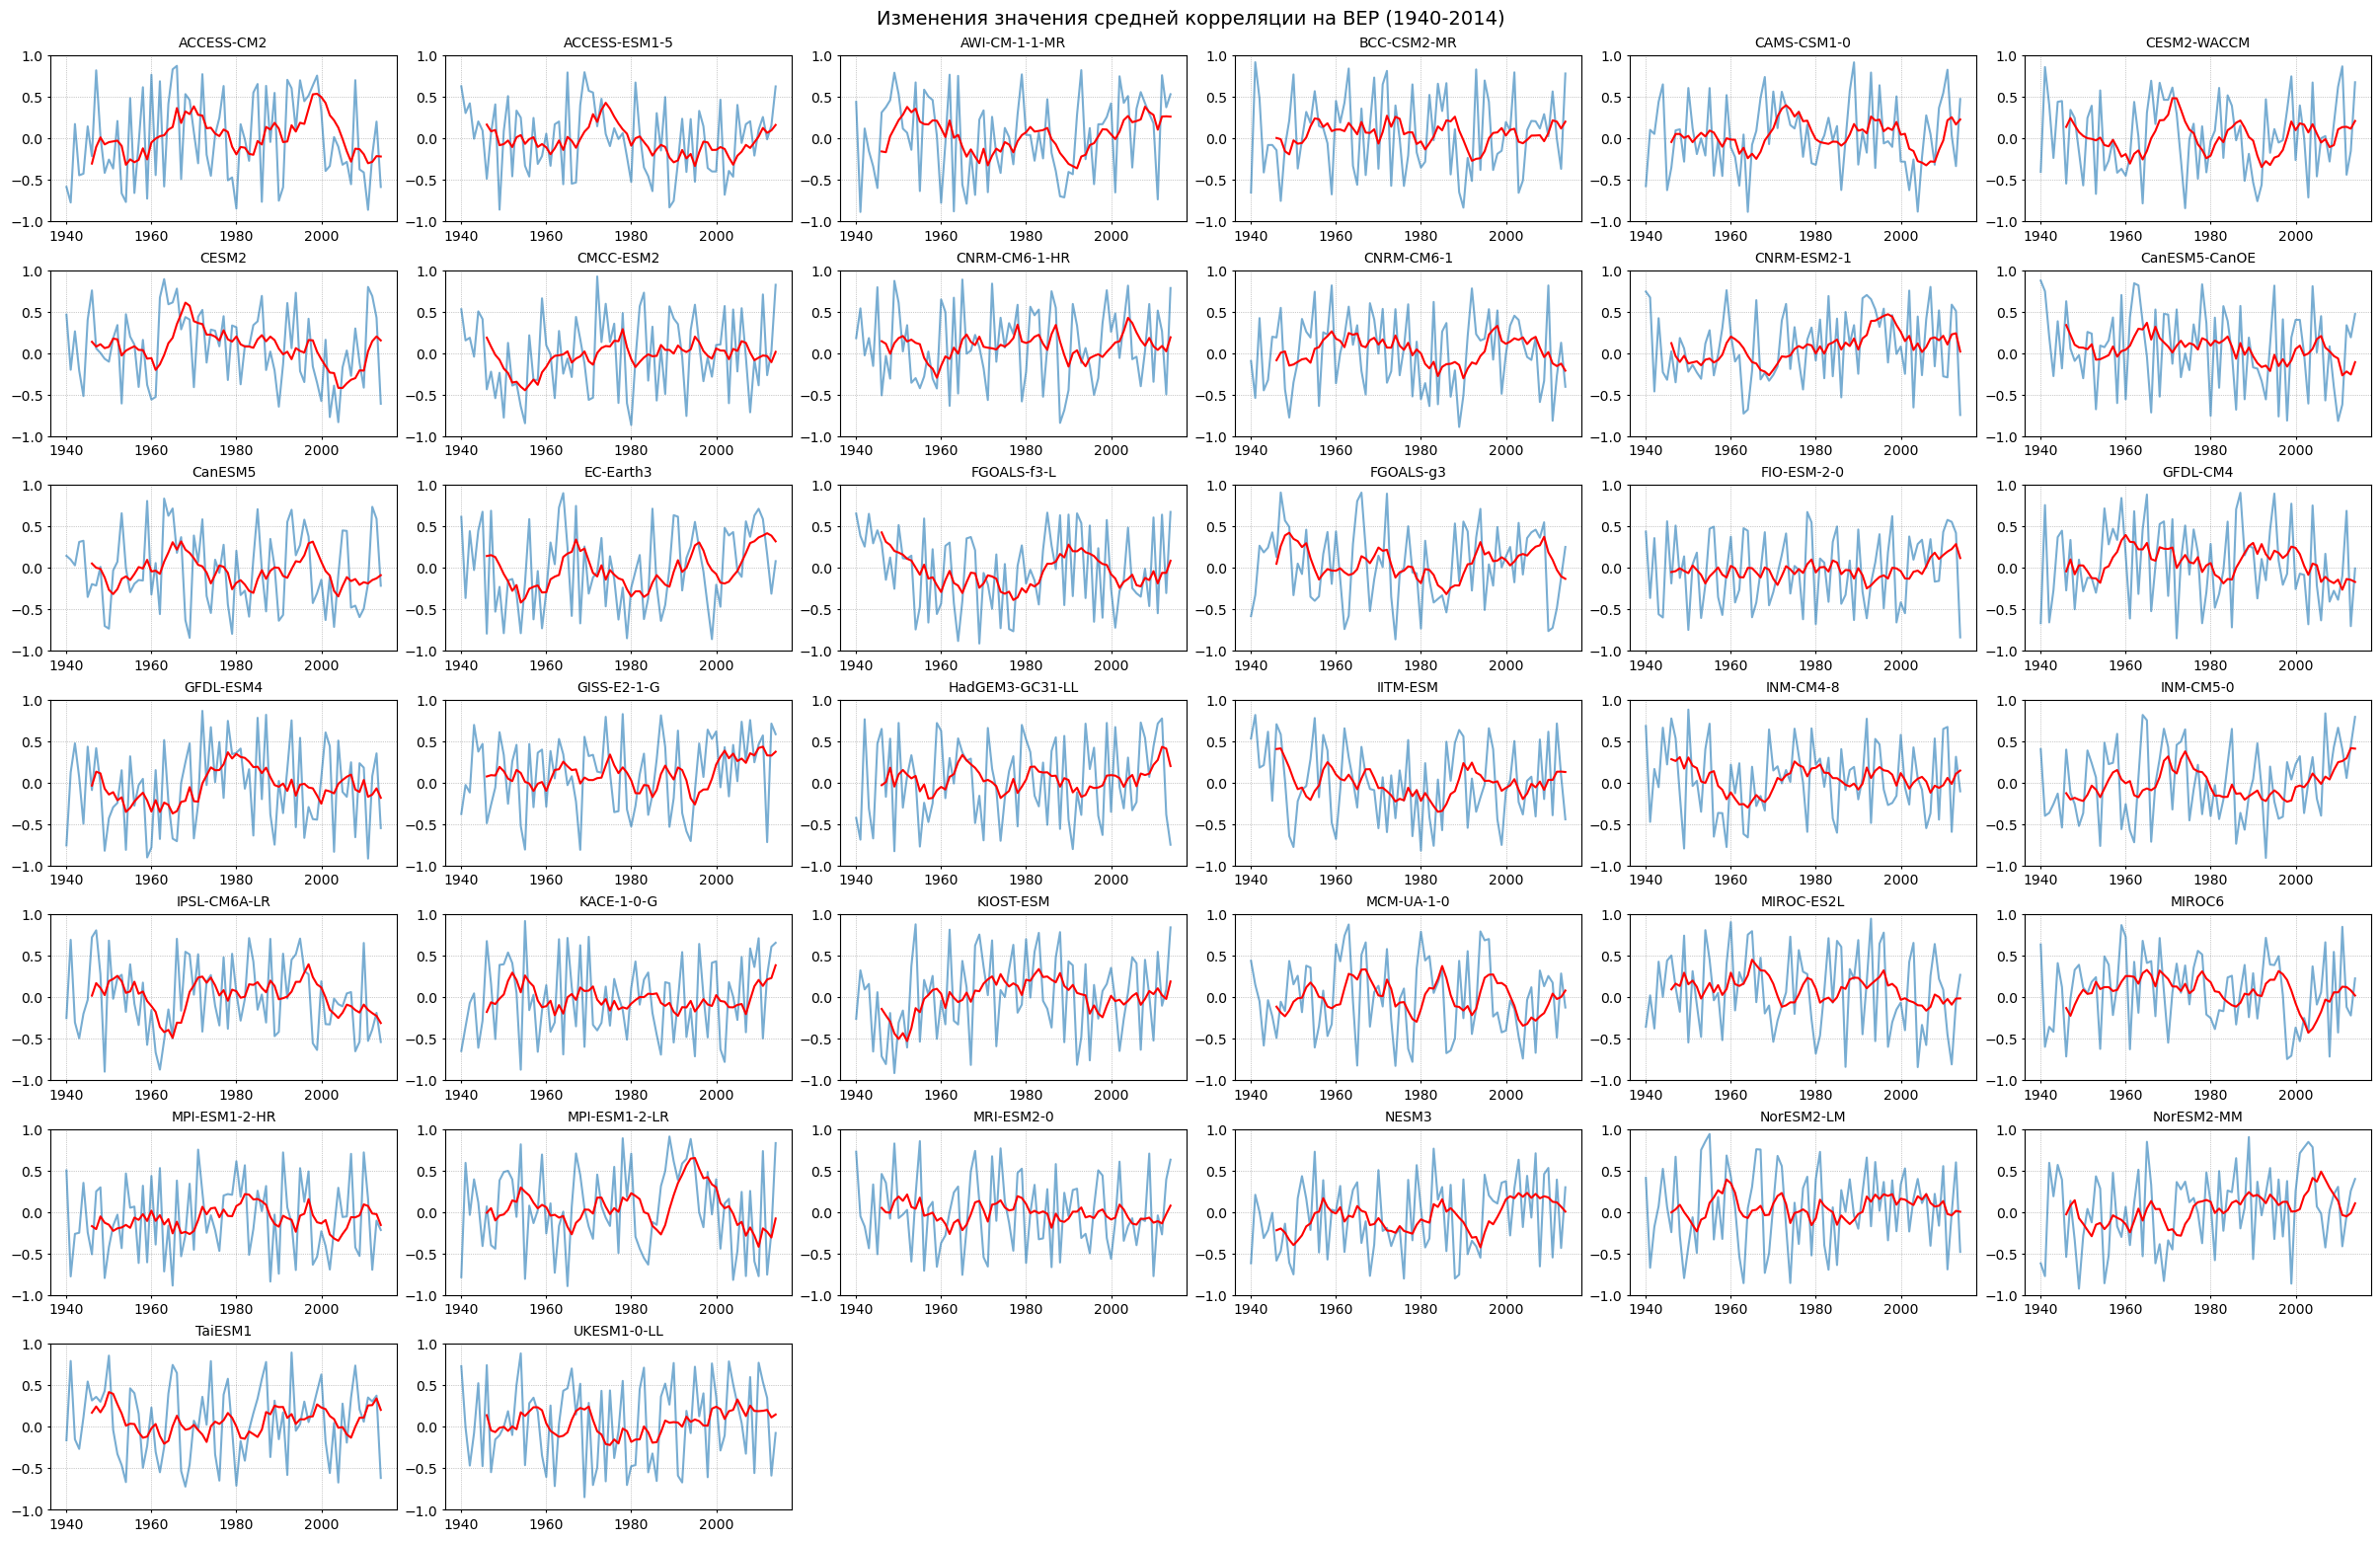

In [506]:
def data_plot (keyword, stopword, data_dict, columns, pos_in_filename, title, fig_name, step):

    #### Displayig 25 fldcor --- as 25 plots with y = value and x = time
    
    # making a list of files for display
    if keyword == '' and stopword == '':
        data_list = np.array([file for file in data_dict.keys()])
    elif stopword == '':
        data_list = np.array([file for file in data_dict.keys() if keyword in file])
    else:
        data_list = np.array([file for file in data_dict.keys() if (keyword in file and not stopword in file)])
    data_list = np.sort(data_list)
    n_subs = m.ceil(len(data_list)/columns)*columns
    
    fig, ax = plt.subplots(n_subs//columns, columns, figsize=(4*columns, 1.5+2*(n_subs//columns)), layout='constrained') 
      
    fig.suptitle (title, fontsize=14)
    
    array = data_dict[data_list[0]]
    df = array.to_dataframe(['time', 'bnds', 'lon', 'lat']).reset_index()
    roll = df.rolling(step).mean()
    row = 0 // columns
    column = 0 % columns
    
    for i in range(len(data_list)):
        row = i // columns
        column = i % columns
       
        variable = str(list(data_dict[data_list[i]].variables)[-1])
        name = str('-'.join(data_list[i].split('_')[pos_in_filename:next((index for index, elem in enumerate(data_list[i].split('_')) if 'ssp' in elem), None)]))
        array = data_dict[data_list[i]]
        df = array.to_dataframe(['time', 'bnds', 'lon', 'lat']).reset_index()
        df = df[df['bnds'] == 1]
        
        ax[row, column].plot(np.arange(1940, 2015), df[variable], alpha=0.6)
        
        ax[row, column].set_ylim(-1, 1)  
        ax[row, column].set_title(name, fontsize=10)
        ax[row, column].tick_params(length=2, labelsize=10)

        if step > 1:
            df = array.to_dataframe(['time', 'bnds', 'lon', 'lat']).reset_index()
            df = df[df['bnds'] == 1]
            
            roll = df.rolling(step).mean()
            ax[row, column].plot(np.arange(1940, 2015), roll[variable], linestyle='-', color='red')
    
    for i in range(n_subs):
        row = i // columns
        column = i % columns
        if i >= len(data_list):
            fig.delaxes(ax[row][column])

        ax[row, column].grid(color='black', linestyle='dotted', linewidth=0.5, alpha=0.4)
    plt.show()
    if (fig_name != '' and not '.' in fig_name):    fig.savefig('t7_fig/'+fig_name+'.png', dpi=300)
    if (fig_name != '' and fig_name.endswith('.eep')):    fig.savefig('t7_fig/'+fig_name)

## Визуализация

Opened: tas_Amon_ACCESS-CM2_ssp585_r1i1p1f1_185001-210012_r360x180_remap.nc


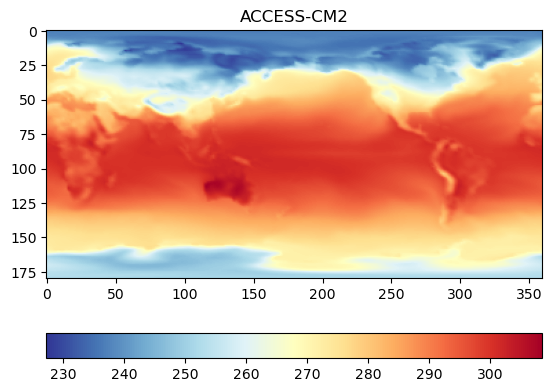

In [462]:
# How to plot one file
file = list(file_dict.keys())[0]
variable = str(list(file_dict[file].variables)[-1])

plt.imshow(file_dict[file][variable][0][::-1], cmap='RdYlBu_r')

plt.title(file.split('_')[2], fontsize=12)
plt.colorbar(orientation='horizontal')
print(f"Opened: {file}")
plt.show()

In [500]:
# Open timcors from my directory
i = 0
for file in file_dict.keys():
    if ('timcor' in file and not '__' in file):
        print (file)
        i+=1
print(f"Total: {i}")

Total: 38


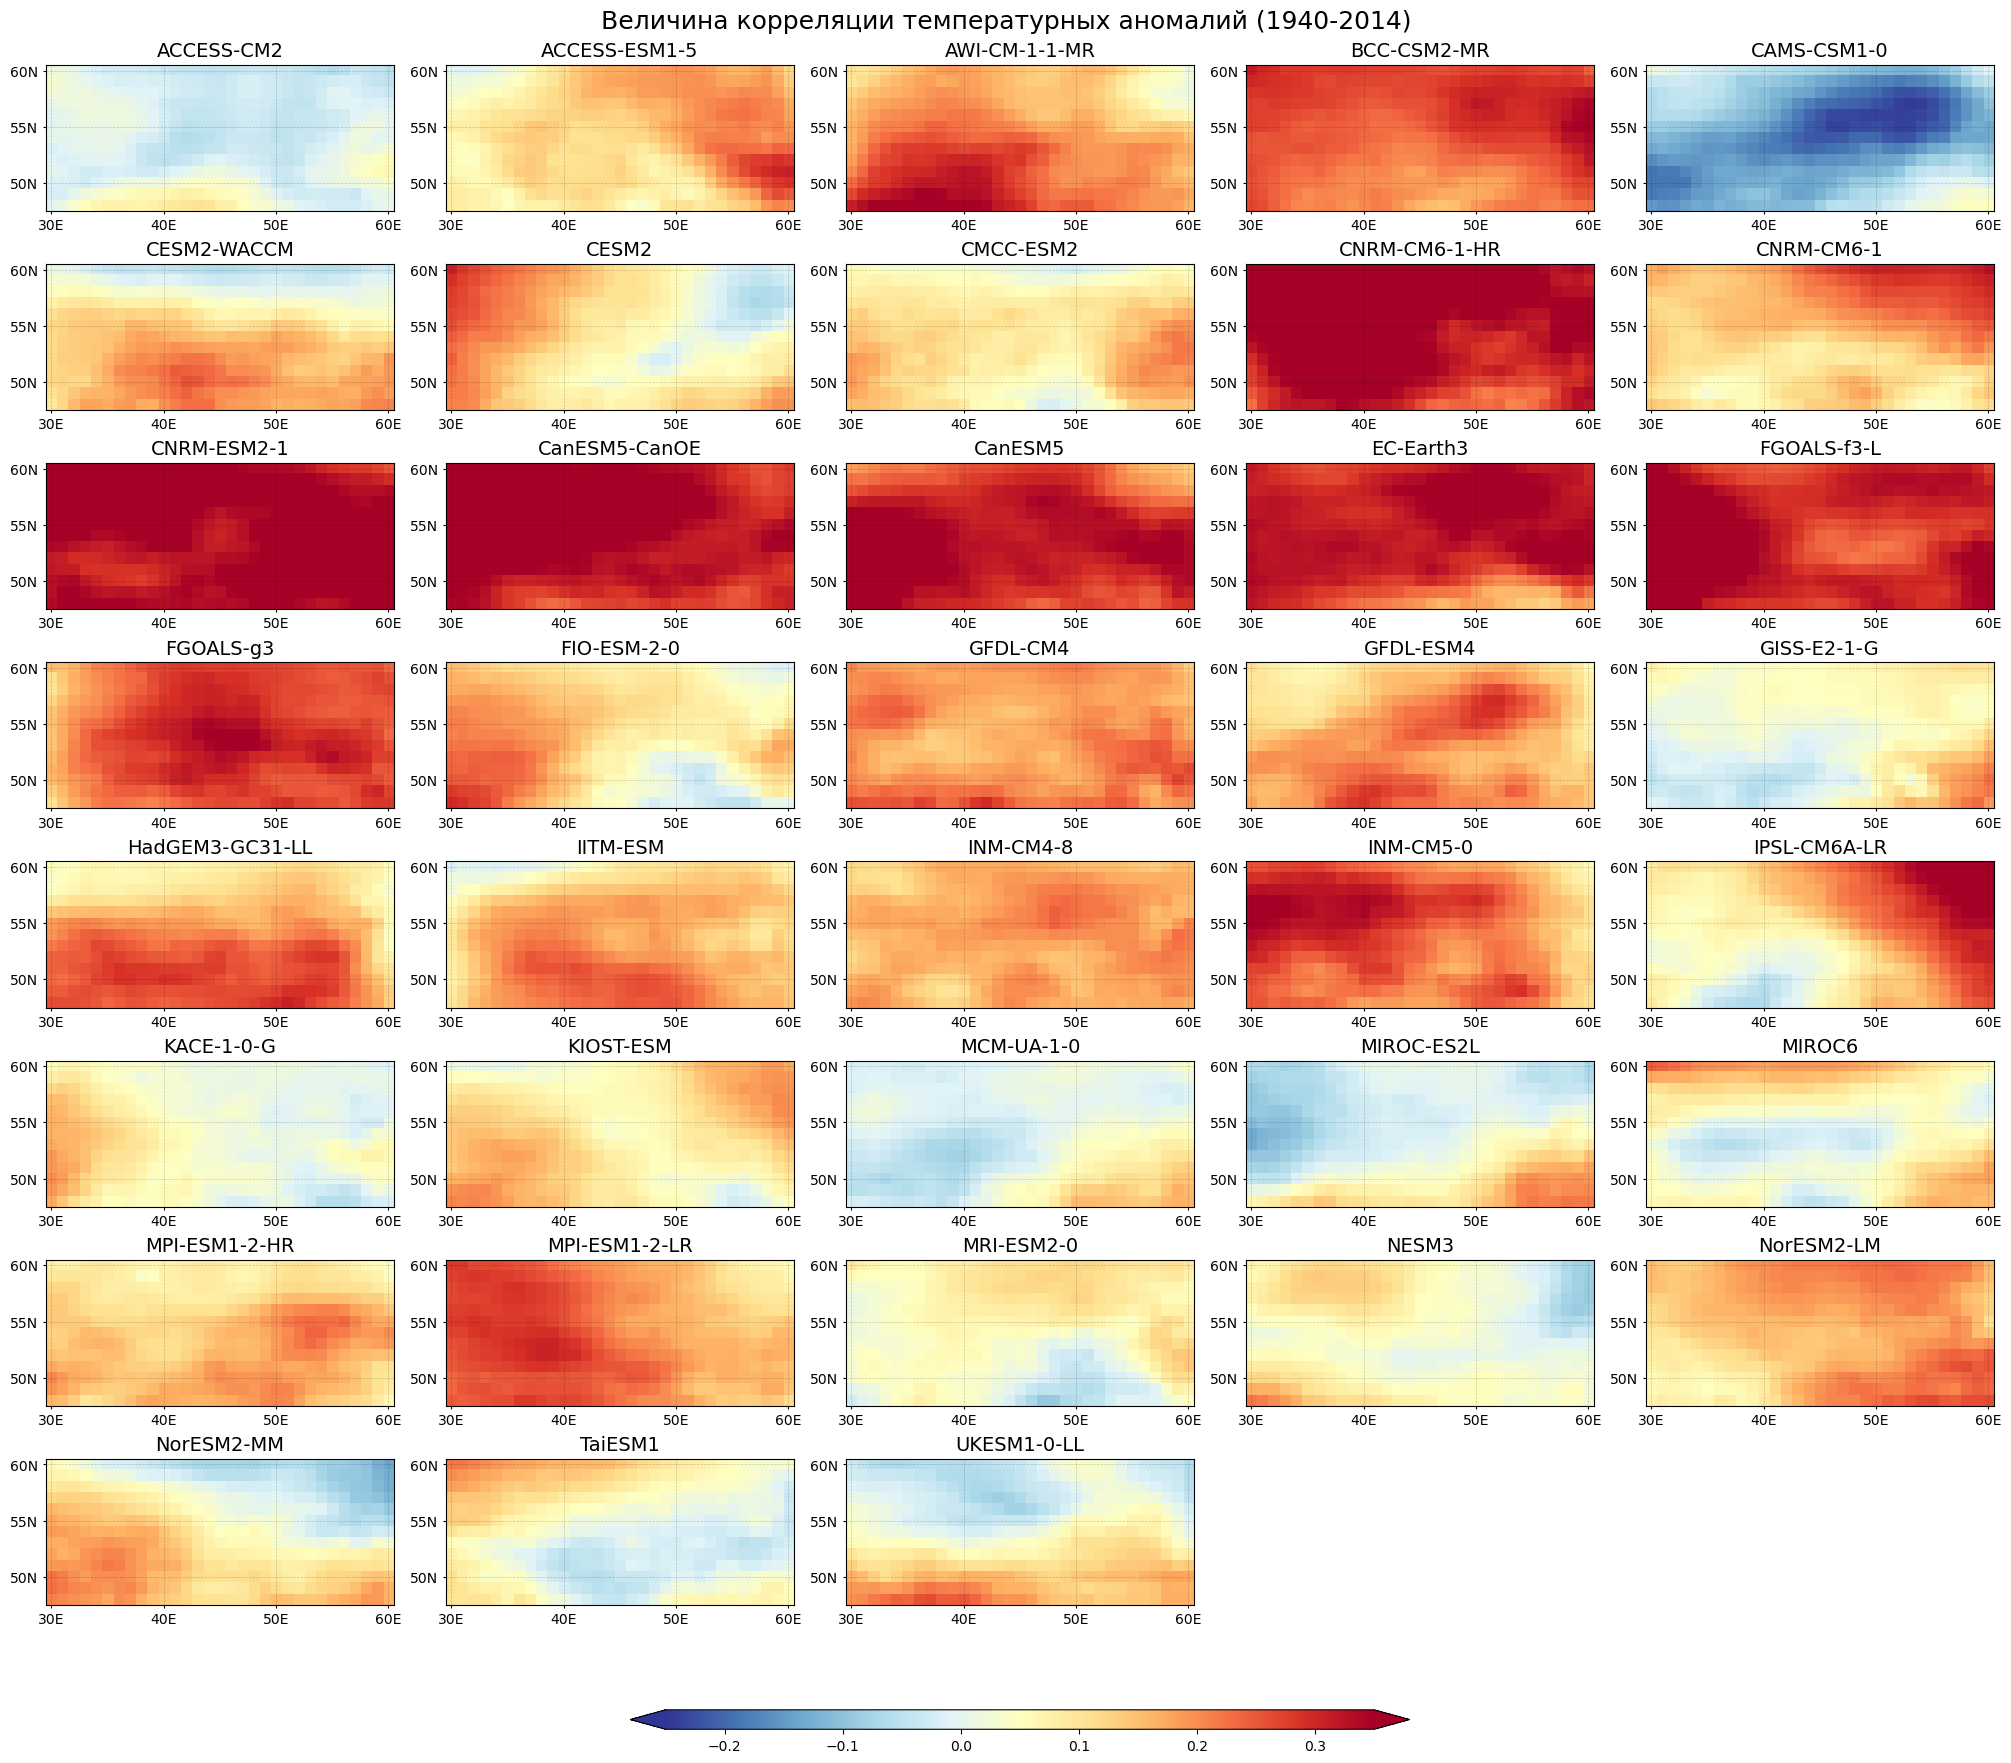

In [475]:
data_disp ('', '', timcor, 5, 3, 4, 3, "Величина корреляции температурных аномалий (1940-2014)", -0.25, 0.35, '')

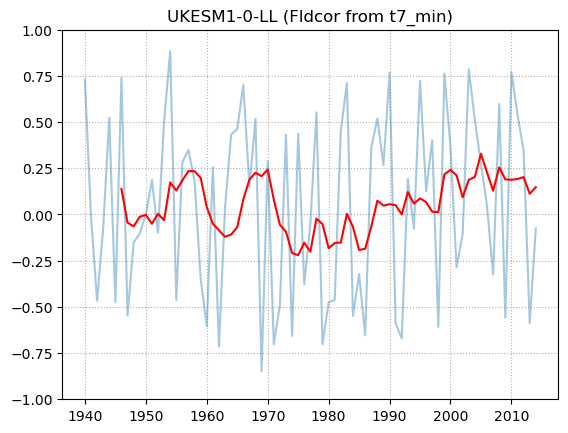

In [468]:
# How to convert everything into pd dataFrame while plotting fldcor
file = 'fldcor_tas_Amon_UKESM1-0-LL_ssp585_r1i1p1f2_185001-210012_r360x180_remap_C_regular_axis_year_anom_box_ymean.nc'
df = fldcor[file].to_dataframe(['time', 'bnds', 'lon', 'lat']).reset_index()
step = 7
df = df[df['bnds'] == 1]

plt.plot(np.arange(1940, 2015,1), df['tas'], alpha=0.4)

roll = df.rolling(step).mean()
plt.plot(np.arange(1940, 2015,1), roll['tas'], linestyle='-', color='red')

plt.title(file.split('_')[3] + " (Fldcor from t7_min)")
plt.grid(linestyle=':')
plt.ylim(-1,1)
plt.show()

In [470]:
# Open fldcors from my directory
i = 0
for file in file_dict.keys():
    if ('fldcor' in file and not 'timmean' in file):
        print (file)
        i+=1
print(f"Total: {i}")

fldcor_tas_Amon_UKESM1-0-LL_ssp585_r1i1p1f2_185001-210012_r360x180_remap_C_regular_axis_year_anom_box_ymean.nc
fldcor_tas_Amon_ACCESS-CM2_ssp585_r1i1p1f1_185001-210012_r360x180_remap_C_regular_axis_year_anom_box_ymean.nc
fldcor_tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_185001-210012_r360x180_remap_C_regular_axis_year_anom_box_ymean.nc
fldcor_tas_Amon_AWI-CM-1-1-MR_ssp585_r1i1p1f1_185001-210012_r360x180_remap_C_regular_axis_year_anom_box_ymean.nc
fldcor_tas_Amon_BCC-CSM2-MR_ssp585_r1i1p1f1_185001-210012_r360x180_remap_C_regular_axis_year_anom_box_ymean.nc
fldcor_tas_Amon_CAMS-CSM1-0_ssp585_r1i1p1f1_185001-210012_r360x180_remap_C_regular_axis_year_anom_box_ymean.nc
fldcor_tas_Amon_CESM2-WACCM_ssp585_r1i1p1f1_185001-210012_r360x180_remap_C_regular_axis_year_anom_box_ymean.nc
fldcor_tas_Amon_CESM2_ssp585_r1i1p1f1_185001-210012_r360x180_remap_C_regular_axis_year_anom_box_ymean.nc
fldcor_tas_Amon_CMCC-ESM2_ssp585_r1i1p1f1_185001-210012_r360x180_remap_C_regular_axis_year_anom_box_ymean.nc
fldcor

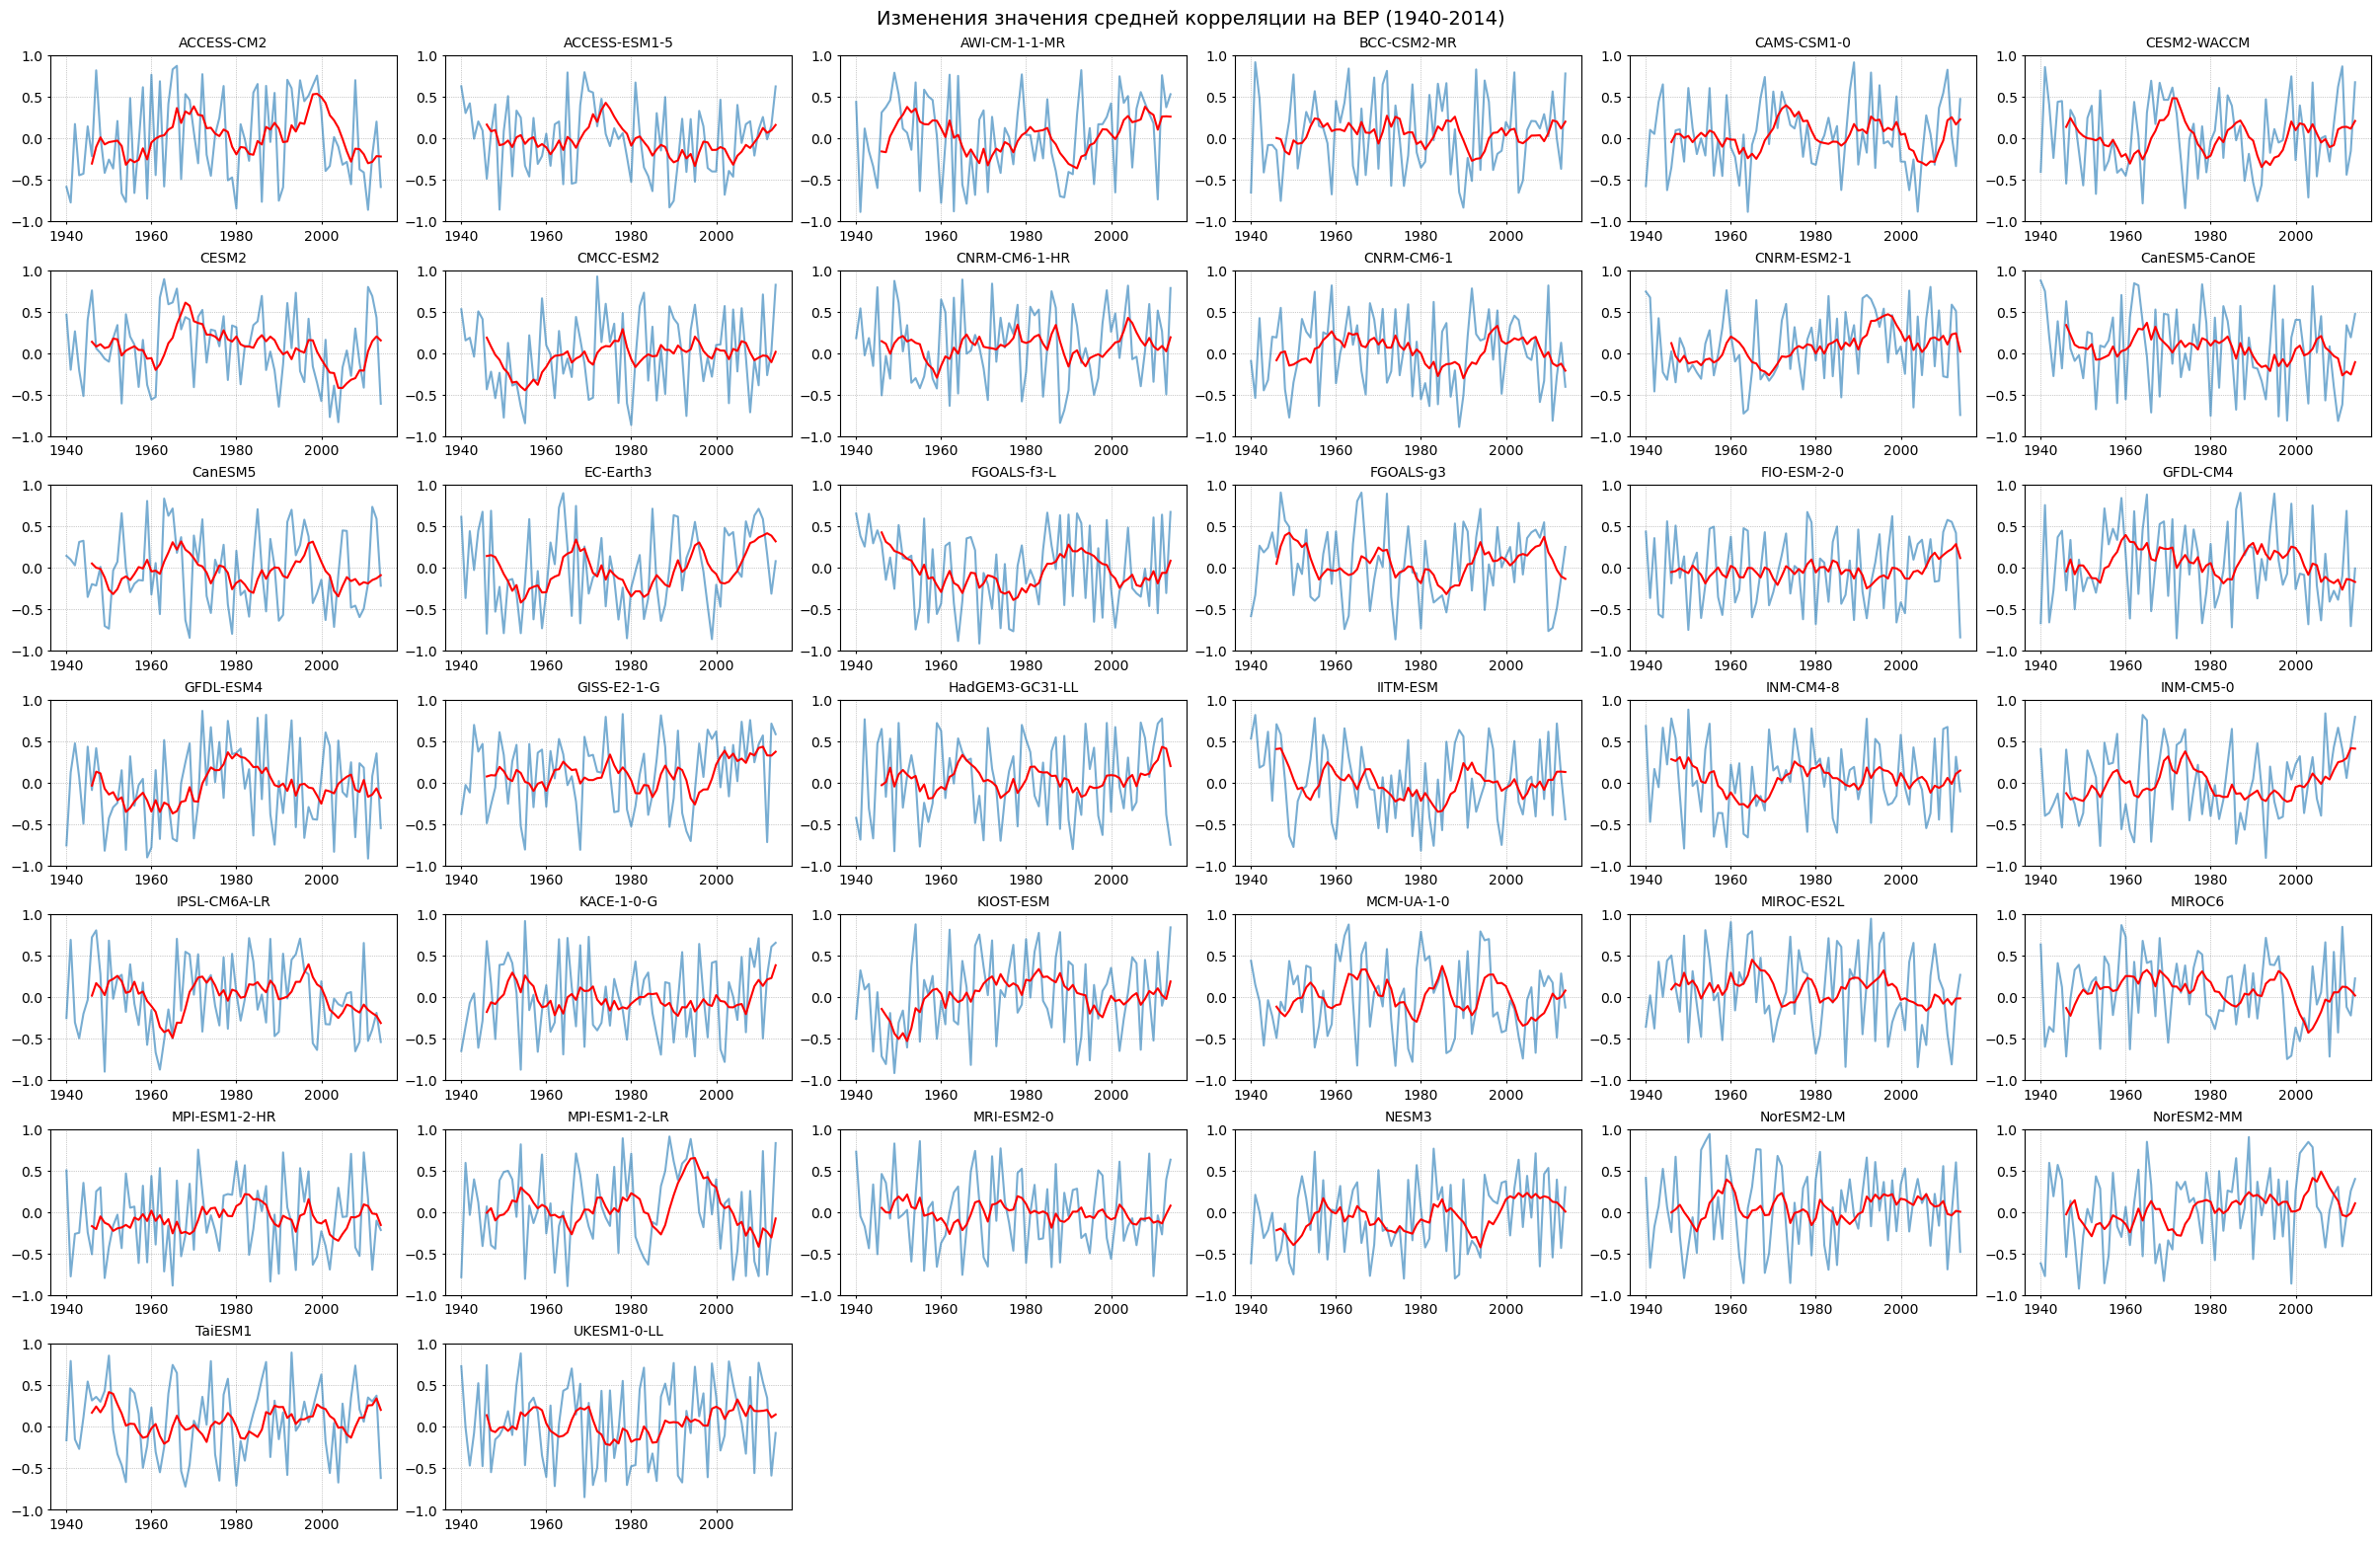

In [507]:
data_plot ('fldcor', 'timmean', file_dict, 6, 3, "Изменения значения средней корреляции на ВЕР (1940-2014)", '', 7)

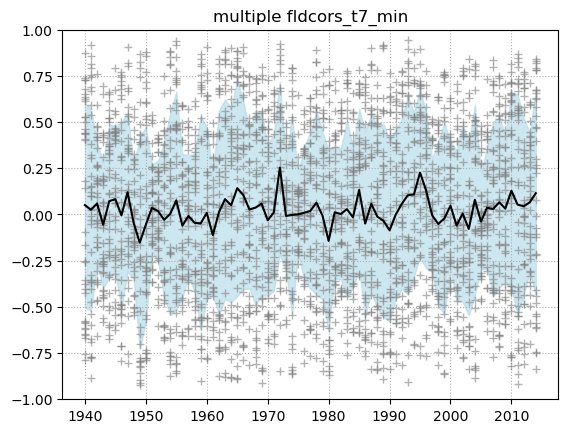

In [560]:
# Plotting many fldcors on one plot
step = 7
df = df[df['bnds'] == 1]
dfs = []
for file in list(fldcor.keys()):
    df = file_dict[file].to_dataframe(['time', 'bnds', 'lon', 'lat']).reset_index()
    df = df[df['bnds'] == 1]
    dfs.append(df)
    plt.plot(np.arange(1940, 2015,1), df['tas'], alpha=0.6, marker='+', linestyle="none", color='gray')

    roll = df.rolling(step).mean()
#     plt.plot(np.arange(1940, 2015,1), roll['tas'], linestyle='--', alpha=0.4)

df_conc = pd.concat(dfs, axis=1)
roll_conc = df_conc.tas.mean(axis=1).rolling(step).mean()

# plt.plot(np.arange(1940, 2015,1), roll_conc, linestyle='--', alpha=1, color='red')
plt.plot(np.arange(1940, 2015,1), df_conc.tas.mean(axis=1), linestyle='-', alpha=1, color='black')
plt.fill_between(np.arange(1940, 2015,1), df_conc.tas.mean(axis=1)+df_conc.tas.std(axis=1), df_conc.tas.mean(axis=1)-df_conc.tas.std(axis=1), color='lightblue', alpha=0.6)

plt.title("multiple fldcors_t7_min")
plt.grid(linestyle=':')
plt.ylim(-1,1)
plt.show()
# plt.savefig("many_fldcors_t7_min.png")

## Оценка моделей: средняя корреляция

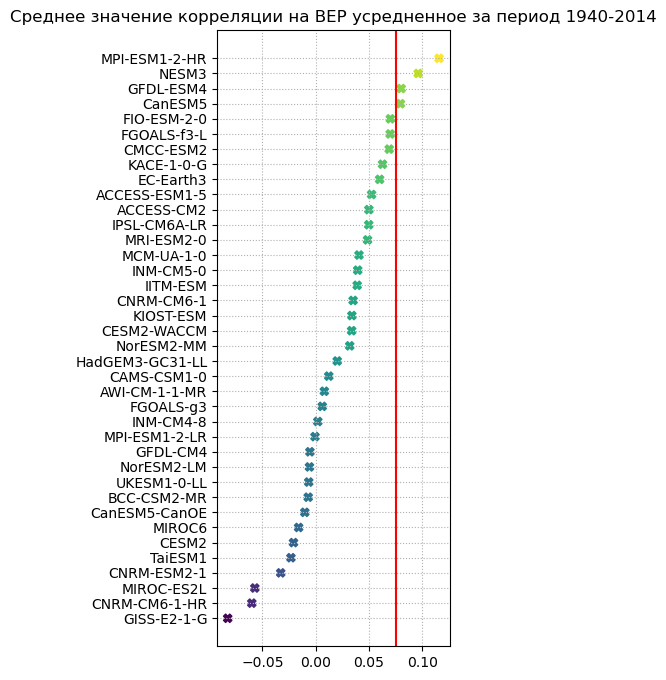

In [663]:
# Ranking models
model_df = pd.DataFrame(columns=['model', 'timmean', 'shift', 'slope'])

plt.figure(figsize=(3, 8))

# file = 'timmean_fldcor_tas_Amon_ACCESS-CM2_ssp585_r1i1p1f1_185001-210012_r360x180_remap_C_regular_axis_year_anom_box_ymean.nc'

for i, file in enumerate(file_list):  
    if 'timmean' in file:
        model_df.loc[i, 'model'] = file.split('_')[4]
        model_df.loc[i, 'timmean'] = file_dict[file].tas.values[0][0][0]
timmean_sorted = model_df.sort_values(by='timmean', ascending=False).reset_index()

plt.scatter(model_df.sort_values(by='timmean', ascending=True).reset_index().timmean, model_df.sort_values(by='timmean', ascending=False).reset_index()['model'], marker='X', c=model_df.sort_values(by='timmean', ascending=True).reset_index()['timmean'], cmap='viridis')
plt.yticks(model_df.model)
plt.grid(linestyle=':')

plt.axvline(x=0.075, color='red', linestyle='-')         # <-- treshold line
plt.title("Среднее значение корреляции на ВЕР усредненное за период 1940-2014")

plt.show()

## Тренды

In [674]:
# Add dataframe for reanalysis
for file in file_list:
    if 'ERA5' in file and not '_ERA5' in file:
        reanalysis = file
rean_df = pd.DataFrame({'model':['ERA5'], 'timmean':[1], 'shift':[float(tr_A[reanalysis].t2m.values)], 'slope':[float(tr_B[reanalysis].t2m.values)]})
rean_df

,model,timmean,shift,slope
0,ERA5,1,-0.827001,0.027118


ERA5_t2m_1_2022_C_model_grid_year_anom_box_ymean.nc


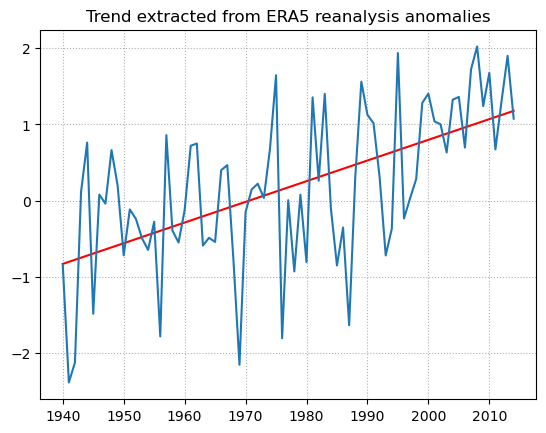

In [841]:
# Display trends in anomalies_box_yearmean
file = list(tr_A.keys())[0]
print(file)
a = tr_A[file].t2m.values[0][0][0]
b = tr_B[file].t2m.values[0][0][0]

conc_y = []
x = np.linspace (1940, 2014, 75)

y = a + b*x 
s = y - fldmean_anom.fldmean
y_shift = y - s.mean()
plt.plot(x, y_shift, linestyle='-', color='red')
plt.plot(x, fldmean_anom.fldmean)
plt.title("Trend extracted from ERA5 reanalysis anomalies")
plt.grid(linestyle=':')
plt.show()

In [794]:
print(reanalysis)
fldmean_anom = pd.DataFrame(columns=['timestep', 'fldmean'])
for i in range(len(file_dict[reanalysis].time.values)):
    time0 = pd.DataFrame(file_dict[reanalysis].t2m.values[i,0,:,:]).mean().mean()
#     time1 = pd.DataFrame(file_dict['ERA5_t2m_1_2022_C_model_grid'].t2m.values[i,0,:,:])
    fldmean_anom.loc[i, :] = [i, time0]
# fldmean_anom

ERA5_t2m_1_2022_C_model_grid_year_anom_box_ymean.nc


In [822]:
fldmean_anom_model = pd.DataFrame(columns=['timestep', 'fldmean'])
# for i in range(len(file_dict[file_list[0]].time.values)):
#     time0 = pd.DataFrame(file_dict[file_list[0]].tas.values[i, 0, :, :]).mean().mean()
#     time1 = pd.DataFrame(file_dict['ERA5_t2m_1_2022_C_model_grid'].t2m.values[i,0,:,:])
#     fldmean_anom.loc[i, :] = [i, time0]
file_dict[file_list[0]].tas['lat' == 0]['lon' == 0].attrs

{'standard_name': 'air_temperature',
 'long_name': '2m temperature',
 'units': 'K'}

In [842]:
# Add all values in data frame
x = np.linspace (1940, 2014, 75)

for i, file in enumerate(tr_A.keys()):
#     index = int(model_df.index[model_df['model'] == file.split('_')[3]])
    variable = str(list(tr_B[file].variables)[-1])

    a_value = float(tr_A[file][variable].values)
    b_value = float(tr_B[file][variable].values)
    model_df.loc[i, 'shift'] = a_value
    model_df.loc[i, 'slope'] = b_value
    
    y = a_value + b_value*x
    plt.plot(x, y, alpha=0.9, linestyle='-', label=if file.split('_')[2] == '1': 'ERA5' else: file.split('_')[2])

    plt.title("Trends in t7_min")
    plt.legend()
    
y = a + b*x     
plt.plot(x, y, label='ERA5', color='black', linestyle='--')
plt.legend(fontsize=4)
plt.show()
# plt.savefig("trends_t7_min_200.png")

# model_df

SyntaxError: invalid syntax (1058849302.py, line 14)

In [ ]:
plt.figure(figsize=(16,10))

Lon = electric_vehicles['Vehicle Location Lon']
Lat = electric_vehicles['Vehicle Location Lat']
electric_range = electric_vehicles['Electric Range']

plt.scatter(Lon, Lat, c=electric_range)
plt.axis('equal')
plt.ylabel('Широта', fontsize=18)     
plt.xlabel('Долгота',fontsize=18)

cbar = plt.colorbar()
cbar.set_label('Дальность поездки', fontsize=18)
cbar.ax.tick_params(labelsize=16) # размер цифирок

plt.gca().tick_params(labelsize=18)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming model_df is your pandas DataFrame with 'timmean' and 'slope' columns

plt.figure(figsize=(16,10))

timmean = model_df['timmean']
slope = model_df['slope']
plt.scatter(slope, timmean)

plt.xlabel('slope', fontsize=18)
plt.ylabel('Широта', fontsize=18)
plt.tick_params(labelsize=18)

model_df

In [ ]:
x = np.linspace(1940, 2014)

for file in list(tr_A.keys()):
    y = tr_A[file].tas.values[0][0][0] + tr_B[file].tas.values[0][0][0]*x
    plt.plot(x, y, linestyle='-', label=file.split('_')[3])

plt.xlim(1940, 2014)
plt.title("Mean trends for anom_box_ymean from (t7_min)")
y = file_dict[mean_a].t2m.values[0][0][0] + file_dict[mean_b].t2m.values[0][0][0]*x
plt.plot(x, y, label='ERA5', color='black', linestyle='--')
plt.legend()
# plt.show()


In [ ]:
slope_sorted = model_df.sort_values(by='slope').reset_index()
slope_sorted